In [2]:
import numpy as np
from scipy.stats import levy_stable
from scipy.stats import levy
from scipy.stats import pareto
from scipy.stats import lognorm
from scipy.special import erfc
from numba import jit
from numba import njit, prange
import matplotlib.pyplot as plt
%matplotlib inline

Simalate the herfindhl for Pareto distribution. 

$$h = \big[\sum_{i=1}^{N} (\frac{S_{it}}{Y_t})^2\big]^{0.5} $$
$$Y_t = \sum_{i=1}^{N} S_{it} $$

Except for $\zeta=1$, also assume that $\zeta$ is 1.059 following Axtell(2001).

In [4]:
σ_π = 0.12
a = 1
ζ = 1  # Zipf's law
x0 = a**(1/ζ)
N = 1000000
sim = 1000

In [5]:
@njit(parallel=True)
def herfindahl(nSim, ζ, N=1000000):
    
    h = np.zeros(nSim)
    for i in range(nSim):    
        size = (np.random.pareto(ζ, N) + 1) * x0         
        h[i] = np.sqrt(np.sum(np.square(size / np.sum(size))))

    return h    

h = herfindahl(nSim=1000, ζ=1)
print(np.median(h))

0.12012269209028266


#### Match the mean and median provided that the log-normal distribution is cut off under some $ \bar{x}$.
Given the Pareto distribution with tail index $\zeta > 1$, the density function is
\begin{equation}
    f_P(x)=
    \begin{cases}
      \frac{\zeta {\bar{x}}^{\zeta}}{x^{\zeta+1}}, & \text{if}\ x\geq \bar{x} \\
      0, & \text{otherwise}
    \end{cases}
  \end{equation}
Then, the corresponding mean and median are $\frac{\zeta \bar{x}}{\zeta-1}$ and $\bar{x} 2^{1/\zeta}$, respectively. The mean can be obtained by $\mathbb{E}(x)= \int x f_P(x) dx$ and the median is the root for $\frac{1}{2}=F_P(x)$ where $F_P(x)= 1-({\frac{x}{\bar{x}}})^{-\zeta}$ is the cumulative density function for $x \geq \bar{x}$.

If the log-normal distribution is $\ln(x) \sim \mathcal{N}(\mu, \,\sigma)$, then we can use the same approaches to find that its mean and median which are $\exp(\mu + \frac{\sigma^2}{2})$ and $\exp(\mu)$, respectively. In addition, the distribution for log-normal is
$$g(x) = \frac{1}{\sigma x \sqrt{2\pi}} \exp\{ {-\frac{(\ln{x-\mu})^2}{2\sigma^2}} \}$$
Also, let $G(x)$ be the cumulative distribution function of log-normal which is also equal to the CDF of the standard normal $\Phi(\frac{\ln{x}-\mu}{\sigma})$.
$$G(x) = \Phi(\frac{\ln{x}-\mu}{\sigma}) $$ 
Next, I rescale the distribution such that it is zero for $x<\bar{x}$ which has the same cutoff as Pareto distribution.
After setting the minimum value $\bar{x}$ and re-scale the probability function such that $P(x\geq \bar{x})=1$, the distribution is 

\begin{equation}
    \hat{g}(x)=
    \begin{cases}
       \frac{g(x)}{1-G(\bar{x})}, & \text{if}\ x\geq \bar{x} \\
      0, & \text{otherwise}
    \end{cases}
  \end{equation}

  
Since $\hat{g}(x)$ is a scaled $g(x)$, the mean for density $\hat{g}$ is $\frac{1}{1-G(\bar{x})}\exp(\mu + \frac{\sigma^2}{2})$ which is a product of scaling constant and the mean of log-normal. For the median, using its CDF $\hat{G}(x) = \frac{G(x) - G(\bar{x})}{1-G(\bar{x})}$, the median should pin down the belowing equation.  
$$\frac{1}{2} = \frac{G(x) - G(\bar{x})}{1-G(\bar{x})}$$

Thus, the median is  
$$median\,=G^{-1}\big[ \frac{1}{2}(1-G(\bar{x})) + G(\bar{x}) \big] $$

Now, we can try to match the scaled log-normal with Pareto distribution under Zipf's law. Since the first moment is infinite when $\zeta=1$ for Pareto distribution, let $\zeta$ be very close to one but not one. Following the assumption for simulation in (Gabaix, 2011), assume $\bar{x}=1$. Then, fixing the mean and median of Pareto distribution (or fixing $\zeta$ and $\bar{x}$), if the mean and median for scaled log-normal distribution are equal to those of Pareto distribution, we have

\begin{align*}\label{eq:1}
    \text{(mean)}\quad & \frac{1}{1-G(\bar{x})}\exp(\mu + \frac{\sigma^2}{2})= \frac{\zeta}{\zeta-1}\\
    (\text{median})\quad & G^{-1}\big[ \frac{1}{2}(1+G(\bar{x})) \big] =  2^{1/\zeta} \\   
\end{align*}

The median equation can also be written as 
$$ G^{-1}[2 G(2^{1/\zeta}) - 1] = \bar{x}$$

The CDF $G(x)$ is determined by the shape parameters $(\mu, \sigma)$.
To match the distribution, we need to solve the above equations and find the corresponding pair of root $(\mu, \sigma)$ which decides the shape of log-normal. 
Since $G(.)$ is a function of $\Phi(.)$, the median equation contains the inverse of $\Phi(.)$ function which is complicated to solve analytically. Therefore, I try to solve them numerically and first plot the equations (RHS - LHS) with respect to parameters $(\mu, \sigma)$ to find the potential roots.

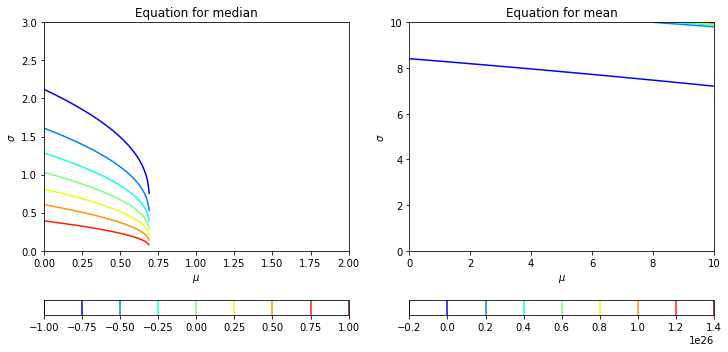

In [5]:
# Solve the equation numerically
eps = np.finfo(float).eps
ζ = 1 + eps

# def obj_median(μ, σ):
#     return - erfc((np.log(2)/ζ - μ)/(np.sqrt(2)*σ))  + erfc(-μ / (np.sqrt(2)*σ)) -1
# def obj_mean(μ, σ):
#     return 2 * np.exp(μ + σ**2 / 2) / erfc(-μ / (np.sqrt(2)*σ)) - ζ / (ζ - 1)
 
def obj_median(μ, σ):
    'median equation, x-bar=1, return LHS - RHS'
    tmp = 2 * lognorm.cdf(2**(1/ζ) ,s=σ,scale=np.exp(μ)) - 1 
    return lognorm.ppf(tmp ,s=σ,scale=np.exp(μ)) - 1

# 
def obj_mean(μ, σ):
    'mean equation, return LHS - RHS '
    return np.exp(μ + 0.5 * σ**2) / (1 - lognorm.cdf(1,s=σ,scale=np.exp(μ))) - ζ / (ζ - 1)

x = np.linspace(eps, 10, 1000)
y = np.linspace(eps, 10, 1000)
xx, yy = np.meshgrid(x, y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
z1 = obj_median(xx, yy)
z2 = obj_mean(xx, yy)
contour1 = ax1.contour(xx, yy, z1, cmap = 'jet')
contour2 = ax2.contour(xx, yy, z2, cmap = 'jet')
cbar1 = fig.colorbar(contour1, orientation="horizontal", ax=ax1)
cbar1 = fig.colorbar(contour2, orientation="horizontal", ax=ax2)
ax2.set_title('Equation for mean')
ax1.set_title('Equation for median')
ax1.set_xlabel('$\mu$')
ax1.set_ylabel('$\sigma$')
ax2.set_xlabel('$\mu$')
ax2.set_ylabel('$\sigma$')
ax1.set_xlim(0, 2)
ax1.set_ylim(0, 3)
plt.show()

Looking at the graphs, the roots are on the line with value 0.0. Since there is no intersection between the lines of root on these tow graphs, there is no pair of $(\mu, \sigma)$ which can pin down the roots for the mean and median equations at the same time. 

#### Match the mean and median withour the cutoff for log-normal.
Without scaling, the lognormal has the mean $\exp(\mu + \frac{\sigma^2}{2})$ and median $\exp(\mu)$ from the previous section. Then, if the mean is equal to the mean of Pareto distribution, we have  
$$ \frac{\zeta \bar{x}}{\zeta-1} = \exp(\mu + \frac{\sigma^2}{2})$$ 
Similarly for median,  
$$\bar{x} 2^{1/\zeta} = \exp(\mu)$$

Given $\zeta$ is close one and $\bar{x}=1$, we can solve the equations for $\mu$ and $\sigma$.
Therefore, $\mu = \ln(\bar{x} 2^{1/\zeta})$ where $\bar{x}=1$ and  $\sigma = (2 \ln(\frac{\zeta}{\zeta-1}) - \frac{2}{\zeta}\ln2)^{1/2}$

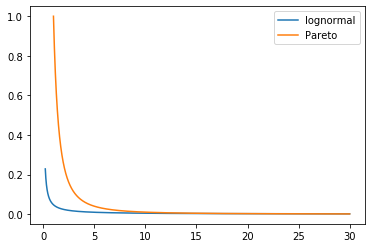

μ=0.69315, σ=8.40839


In [55]:
# Pareto pdf
ζ = 1 + np.finfo(float).eps  # under Zipf's law and the mean is finite
a = 1

f = lambda x: a*ζ / x**(ζ+1)
# lognormal pdf
σ = np.sqrt(2 * (np.log(ζ/(ζ-1)) - 1 / ζ * np.log(2)))
μ = np.log(2) / ζ
g = lambda x: 1/(x*σ*np.sqrt(2*np.pi)) * np.exp(-(np.log(x)-μ)**2 / (2*σ**2))

xd = np.linspace(1,30, 100000)
xd2 = np.linspace(0.2, 30, 100000)
plt.plot(xd2, g(xd2), label='lognormal')
plt.plot(xd, f(xd), label='Pareto')
plt.legend()
plt.show()
print('μ=%1.5f, σ=%1.5f'%(μ, σ))

In [52]:
@njit(parallel=True)
def h_lognormal(nSim, mu, sigma, N=1000000):
    
    h = np.zeros(nSim)
    for i in range(nSim):    
        size = np.random.lognormal(mu, sigma, size=N)        
        mask=size>1
        h[i] = np.sqrt(np.sum(np.square(size[mask] / np.sum(size[mask]))))
    return h    


h = h_lognormal(nSim=1000, mu=0.69315, sigma=8.40839)
print(np.median(h))

0.5942463163571974


 $(\mu, \sigma)=(0.69315, 8.40839)$ is shape for matched log-normal under Zipf's law($\zeta$ is close to one but not one). In this case, the herfindahl is 59.42% which is much higher than 12% of Pareto distribution. 
 
 When firm's growth rate is 12%, the deviation of growth rate $ \sigma_{GDP} = h\sigma $ is around 7.2% for log-normal which is also higher than 1.4% of Pareto.